## Diffusion from Scratch with HuggingFace `diffusers`

Adapting working example from https://huggingface.co/learn/diffusion-course/en/unit1/3 to do sea ice forecasting.

In [73]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
import os
os.chdir("/data/hpcdata/users/anddon76/icenet/icenet-experimental/")
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from utils import IterableIceNetDataSetPyTorch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
dataset = IterableIceNetDataSetPyTorch("dataset_config.exp23_south.json",
                                       "train", batch_size=4, shuffling=False)

In [3]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8, pin_memory=True)

In [4]:
x, y, sw = next(iter(train_dataloader))

Input shape: torch.Size([4, 26, 432, 432])
Output shape: torch.Size([4, 93, 432, 432])


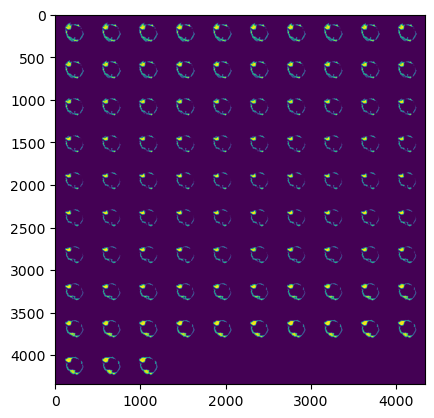

In [30]:
print("Input shape:", x.shape)
print("Output shape:", y.shape)
img = torchvision.utils.make_grid(y[[0]].transpose(0, 1), nrow=10)[0]
plt.imshow(img)
plt.show()

In [31]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return y * (1 - amount) + noise * amount

In [65]:
img = torchvision.utils.make_grid(y[:, [0]])[0]  # first of batch at t = 0, 30, 60, 90
img.shape

torch.Size([436, 1738])

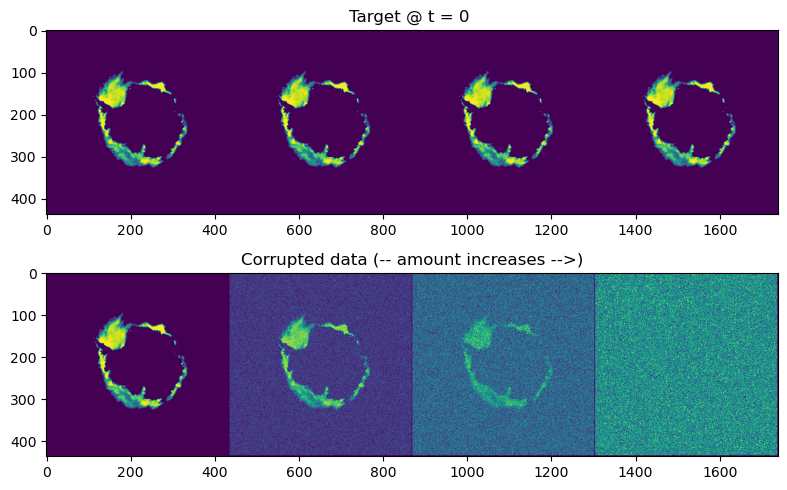

In [67]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
# img = torchvision.utils.make_grid(y[0, [0, 30, 60, 90]].unsqueeze(0).transpose(0, 1))[0]  # first of batch at t = 0, 30, 60, 90
img = torchvision.utils.make_grid(y[:, [0]])[0]  # first of batch at t = 0, 30, 60, 90
axs[0].set_title("Target @ t = 0 ")
axs[0].imshow(img)

# Adding noise
amount = torch.linspace(0, 1, y.shape[0])  # Left to right -> more corruption
noised_y = corrupt(y, amount)

# # Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
# img = torchvision.utils.make_grid(noised_y[0, [0, 30, 60, 90]].unsqueeze(0).transpose(0, 1))[0]  # first of batch at t = 0, 30, 60, 90
img = torchvision.utils.make_grid(noised_y[:, [0]])[0]  # first of batch at t = 0, 30, 60, 90
axs[1].imshow(img)
plt.tight_layout()
plt.show()

In [70]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=93, out_channels=93):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

In [71]:
net = BasicUNet()
x = torch.rand(4, 93, 432, 432)
net(x).shape

torch.Size([4, 93, 432, 432])

In [72]:
sum([p.numel() for p in net.parameters()])

456349

In [76]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8, pin_memory=True)

# How many runs through the data should we do?
n_epochs = 1

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
global_step = 0
for epoch in range(n_epochs):

    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")

    for _, y, _ in train_dataloader:

        # Get some data and prepare the corrupted version
        y = y.to(device)  # Data on the GPU
        noise_amount = torch.rand(y.shape[0]).to(device)  # Pick random noise amounts
        noisy_y = corrupt(y, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_y)

        # Calculate the loss
        loss = loss_fn(pred, y)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "step": global_step
        }
        progress_bar.set_postfix(**logs)
        global_step += 1

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)
plt.show()

Epoch 0:   0%|          | 0/731 [00:00<?, ?it/s]

Epoch 0:  21%|██▏       | 157/731 [06:22<17:54,  1.87s/it, loss=0.0191, step=156]

KeyboardInterrupt: 

Exception in thread Thread-157 (_pin_memory_loop):
Traceback (most recent call last):
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/users/anddon76/micromamba/envs/icenet-3.11/lib/

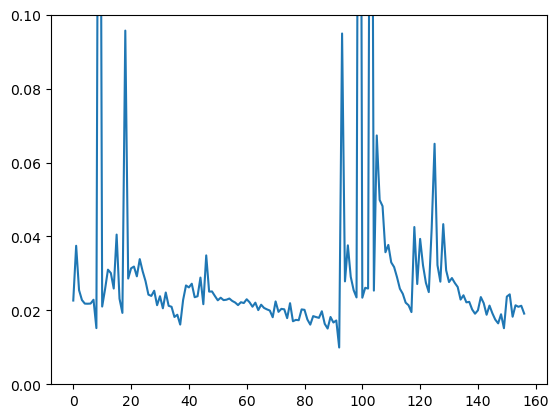

In [79]:
# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)
plt.show()

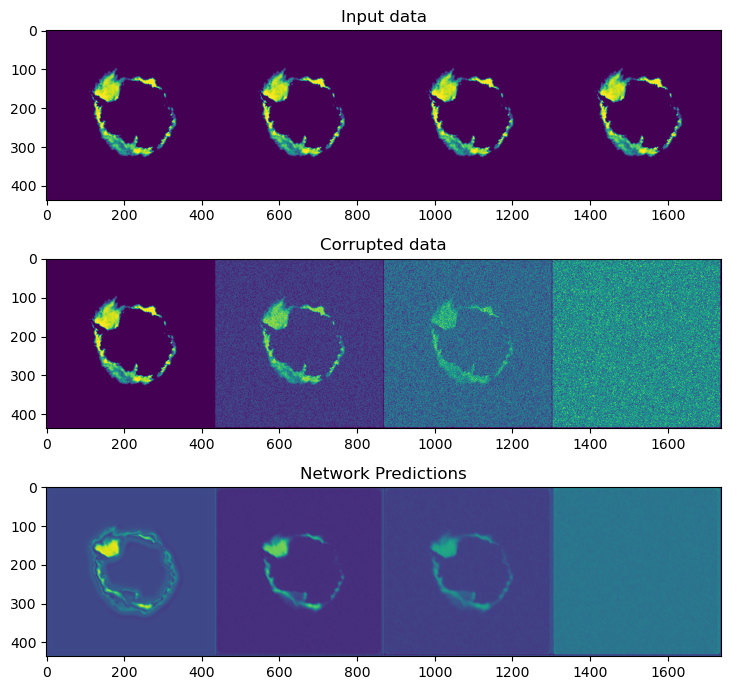

In [81]:
# Fetch some data
_, y, _ = next(iter(train_dataloader))

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, y.shape[0])  # Left to right -> more corruption
noised_y = corrupt(y, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_y.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
img = torchvision.utils.make_grid(y[:, [0]])[0]
axs[0].imshow(img)
axs[1].set_title("Corrupted data")
img = torchvision.utils.make_grid(noised_y[:, [0]])[0]
axs[1].imshow(img)
axs[2].set_title("Network Predictions")
img = torchvision.utils.make_grid(preds[:, [0]])[0]
axs[2].imshow(img)
plt.tight_layout()
plt.show()

In [84]:
pred_output_history[0].shape

torch.Size([4, 93, 432, 432])

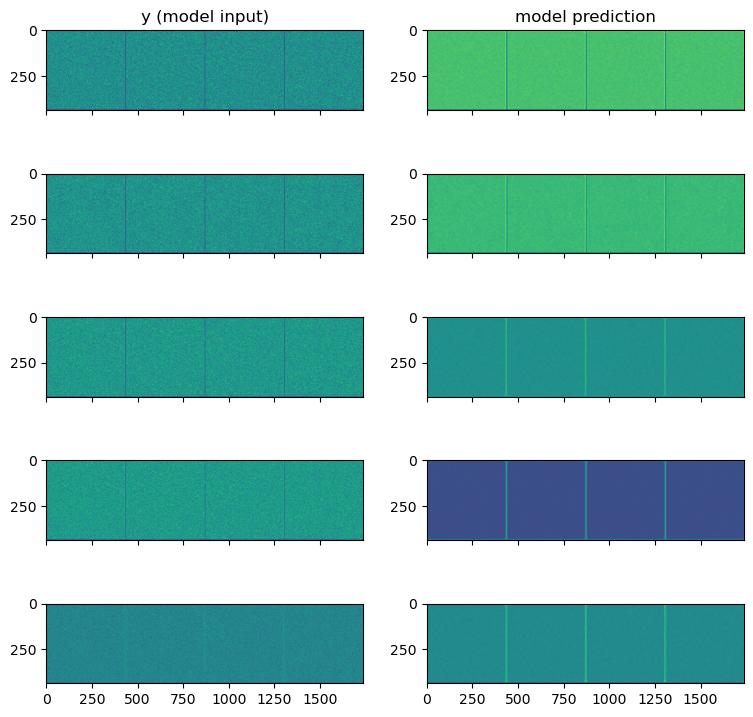

In [86]:
n_steps = 5
y = torch.rand(4, 93, 432, 432).to(device)  # Start from random
step_history = [y.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(y)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    y = y * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(y.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
axs[0, 0].set_title("y (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    img = torchvision.utils.make_grid(step_history[i][:, [0]])[0]
    axs[i, 0].imshow(img)
    img = torchvision.utils.make_grid(pred_output_history[i][:, [0]])[0]
    axs[i, 1].imshow(img)

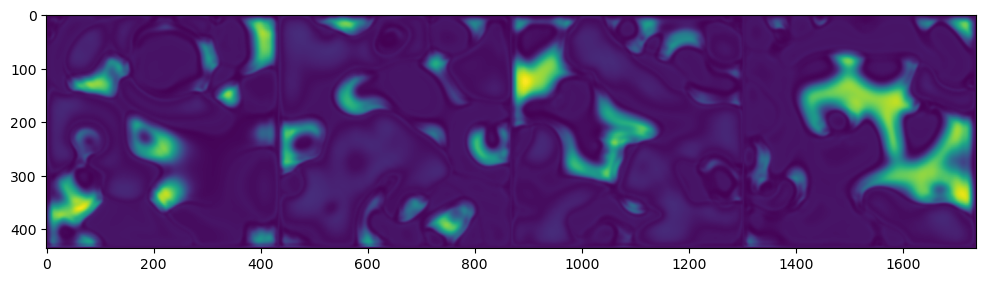

In [89]:
# @markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(4, 93, 432, 432).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((y.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(y)
    mix_factor = 1 / (n_steps - i)
    y = y * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
img = torchvision.utils.make_grid(y.detach().cpu()[:, [0]])[0]
ax.imshow(img)
plt.show()

In [91]:
# @markdown Trying UNet2DModel instead of BasicUNet:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=16, pin_memory=True)

# How many runs through the data should we do?
n_epochs = 1

# Create the network
net = UNet2DModel(
    sample_size=432,  # the target image resolution
    in_channels=93,  # the number of input channels, 3 for RGB images
    out_channels=93,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []
# The training loop
global_step = 0
for epoch in range(n_epochs):

    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")

    for _, y, _ in train_dataloader:

        # Get some data and prepare the corrupted version
        y = y.to(device)  # Data on the GPU
        noise_amount = torch.rand(y.shape[0]).to(device)  # Pick random noise amounts
        noisy_y = corrupt(y, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_y, 0).sample

        # Calculate the loss
        loss = loss_fn(pred, y)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "step": global_step
        }
        progress_bar.set_postfix(**logs)
        global_step += 1
        if global_step > 128:
            break

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
y = torch.rand(4, 93, 432, 432).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((y.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(y, 0).sample
    mix_factor = 1 / (n_steps - i)
    y = y * (1 - mix_factor) + pred * mix_factor

img = torchvision.utils.make_grid(y[:, [0]])[0]
axs[1].imshow(img)
axs[1].set_title("Generated Samples")
plt.show()

Epoch 0:   0%|          | 0/731 [00:00<?, ?it/s]

Epoch 0:   3%|▎         | 22/731 [05:57<2:56:57, 14.98s/it, loss=0.00528, step=21]

KeyboardInterrupt: 

In [ ]:
# Samples
n_steps = 40
y = torch.rand(4, 93, 432, 432).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((y.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(y, 0).sample
    mix_factor = 1 / (n_steps - i)
    y = y * (1 - mix_factor) + pred * mix_factor

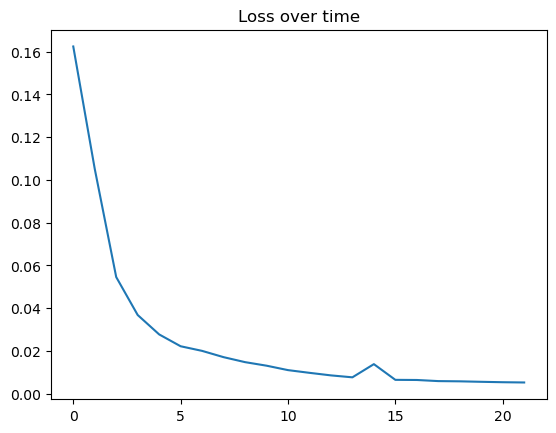

In [96]:
# Losses
plt.plot(losses)
plt.title("Loss over time")
plt.show()

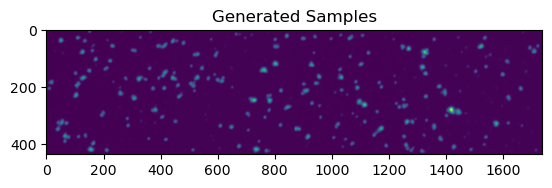

In [97]:
img = torchvision.utils.make_grid(y.detach().cpu()[:, [0]])[0]
plt.imshow(img)
plt.title("Generated Samples")
plt.show()